In [7]:
import os

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import muon as mu
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def plot_qc(adata):
    mito = 'pct_counts_mt' in adata.obs.columns
    if mito:
        ncol = 5
    else:
        ncol = 4
    fig, axs = plt.subplots(1, ncol, figsize=(20, 4))
    sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
    sns.distplot(adata.obs["total_counts"], kde=False, bins=40, ax=axs[1])
    sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[3])
    if mito:
        sns.distplot(adata.obs["pct_counts_mt"], kde=False, bins=60, ax=axs[4])

In [9]:
decimals = 3

In [10]:
# slide names and x, y offsets
slides = {'A1':[12, 5.5],
          'B1':[8.5, 8.5],
          'C1':[10.2, 5],
          'D1':[4, 5]}

In [11]:
path = os.path.join('..', 'data', 'sma')
exp = "V11T17-102" # V11T17-102 V11L12-109 V11T16-085

In [12]:
# for slide in slides.keys():

In [13]:
slide = 'B1'

In [14]:
print(f"{exp}_{slide}")

V11T17-102_B1


In [15]:
mito = pd.read_csv(os.path.join(path, f"mitocarta_human.csv"))

In [16]:
# check if mito['MitoCarta3.0_Evidence'] contains literature, else false
mito['curated'] = [True if 'literature' in x else False for x in mito['MitoCarta3.0_Evidence']]
mito = mito[mito['curated']]
mito_genes = mito['Symbol'].tolist()

In [17]:
slide_path = os.path.join(path, exp, f"{exp}_{slide}", "output_data")
rna_path = os.path.join(slide_path, f"{exp}_{slide}_RNA", "outs")
msi_path = os.path.join(slide_path, f"{exp}_{slide}_MSI" ,f"{exp}_{slide}.Visium.FMP.220826_smamsi.csv")

In [18]:
rna = sq.read.visium(rna_path, counts_file="filtered_feature_bc_matrix.h5")
rna.obs[['x', 'y']] = rna.obsm['spatial']

In [19]:
rna.var_names_make_unique()
rna.var["mt"] = rna.var_names.isin(mito_genes)
sc.pp.calculate_qc_metrics(rna, qc_vars=["mt"], inplace=True)

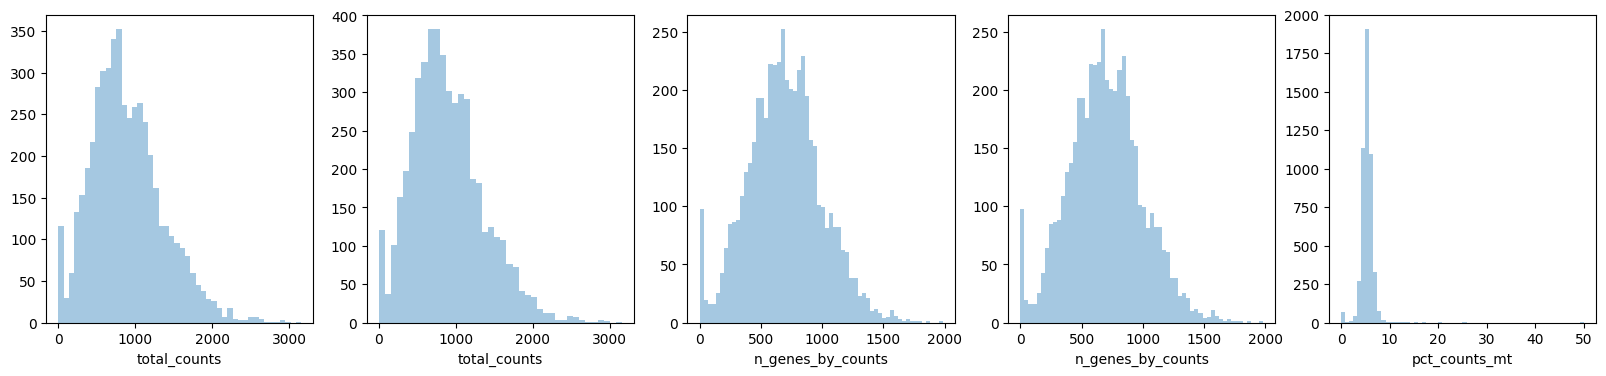

In [20]:
plot_qc(rna)

In [21]:
sc.pp.filter_cells(rna, min_genes=200)
sc.pp.filter_genes(rna, min_cells=10)

sc.pp.filter_cells(rna, min_counts=100)
sc.pp.filter_cells(rna, max_counts=3000)

adata = rna[rna.obs["pct_counts_mt"] < 20]

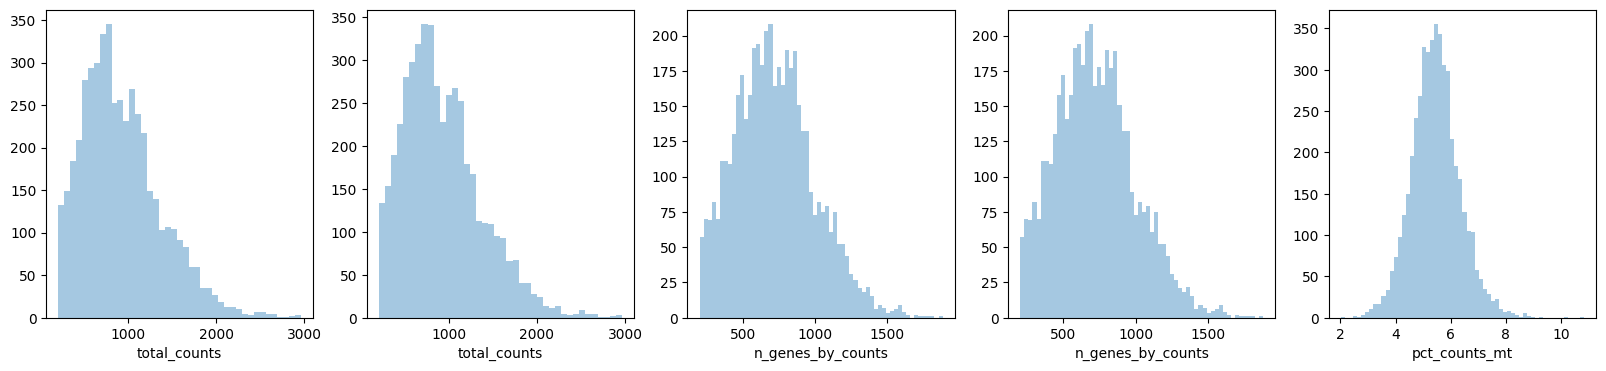

In [22]:
plot_qc(rna)

In [23]:
rna.var_names_make_unique()

In [24]:
# offset
x_offset = slides[slide][0]
y_offset = slides[slide][1]

In [25]:
msi_raw = pd.read_csv(msi_path)
# set x and y columns as index, concat with _ as separator
msi_raw.index = msi_raw[['x', 'y']].astype(str).agg('_'.join, axis=1)
positions = msi_raw[['y', 'x']].values.copy()

In [26]:
# estimate scaling factor
sfactor = rna.uns['spatial'][f"{exp}_{slide}"]['scalefactors']['fiducial_diameter_fullres']
sfactor

# inverse
positions[:, 1] = positions[:, 1].max() - positions[:, 1]

positions[:, 0] = positions[:, 0] + x_offset
positions[:, 1] = positions[:, 1] + y_offset


array_row, array_col = positions[:,0], positions[:, 1]

# scale
positions = positions * sfactor * 0.95
msi = msi_raw.copy().drop(['x', 'y'], axis=1)
msi = sc.AnnData(X=msi.values,
                obs=pd.DataFrame(index=msi.index),
                var=pd.DataFrame(index=msi.columns)
                )
msi.obsm['spatial'] = positions
msi.obs[['x', 'y']] = positions
msi.obs['array_row'] = array_row
msi.obs['array_col'] = array_col
msi.uns = rna.uns.copy()

In [27]:
sc.pp.calculate_qc_metrics(msi, inplace=True)

In [28]:
if slide=='D1':
    msi.layers['raw'] = msi.X.copy()
    sc.pp.normalize_total(msi, target_sum=1e4)
    sc.pp.log1p(msi)
    sc.pp.scale(msi)
    sc.pp.pca(msi)
    sc.pp.neighbors(msi, n_neighbors=10, n_pcs=10)
    sc.tl.leiden(msi, resolution=0.1)
    msi = msi[msi.obs['leiden'] != '2']
    msi.X = msi.layers['raw'].copy()

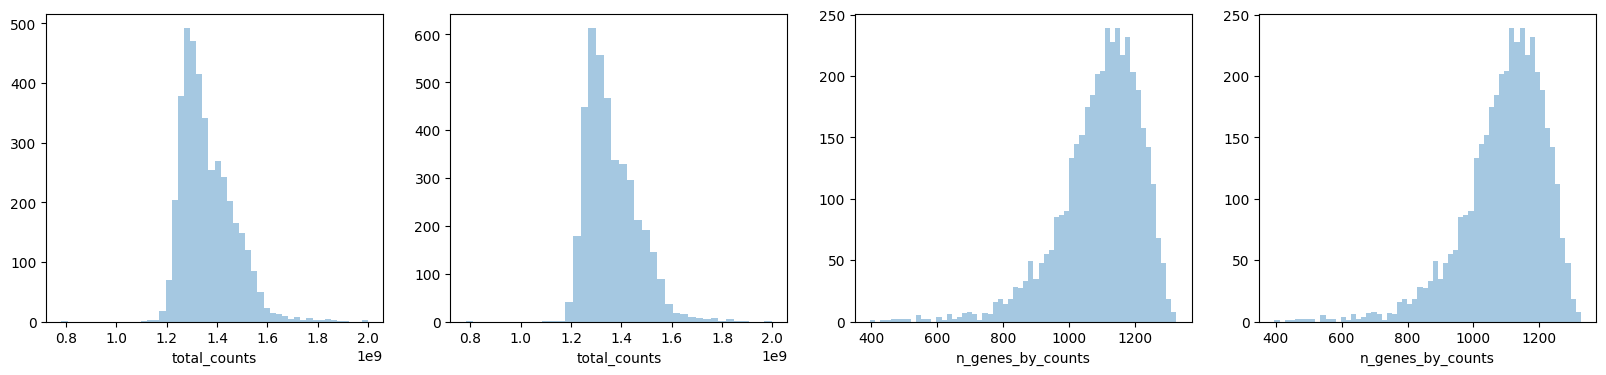

In [29]:
plot_qc(msi)

In [30]:
sc.pp.filter_cells(msi, min_genes=500)
sc.pp.filter_genes(msi, min_cells=30)

sc.pp.filter_cells(msi, min_counts=1.1e9)
sc.pp.filter_cells(msi, max_counts=1.75e9)

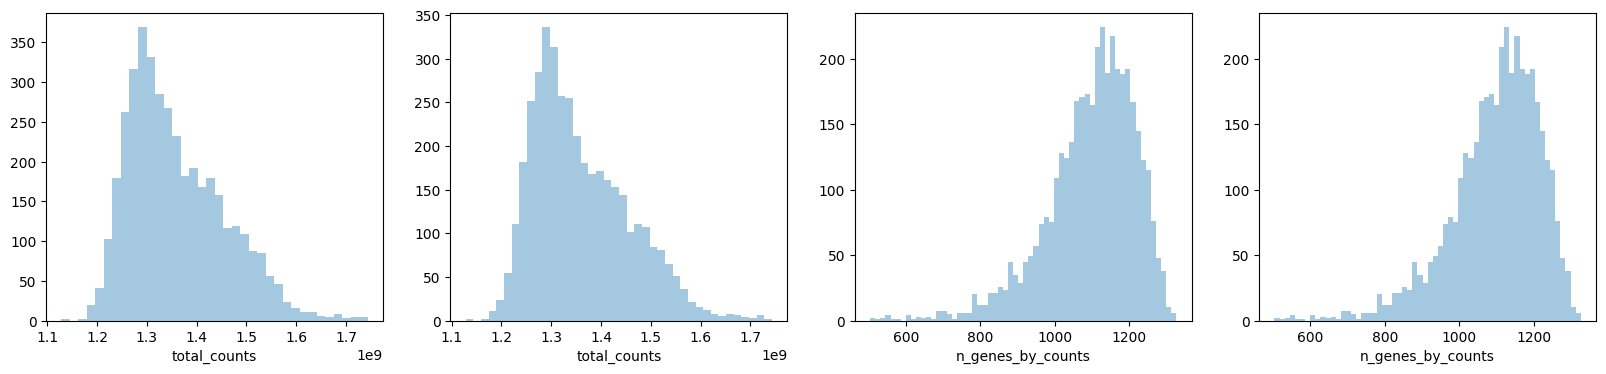

In [31]:
plot_qc(msi)

In [32]:
msi.layers['raw'] = msi.X.copy()
sc.pp.normalize_total(msi, target_sum=1e4)
sc.pp.log1p(msi)
sc.pp.scale(msi)

In [33]:
molecule_weights = {
    'GABA': 371.17556, # 371.18,
    'GABA-H2O': 353.16488, # 353.16 (rounding as in paper)
    'Taurine': 393.12718, # 393.13,
    'Serotonin': 444.20746, # 444.21,
    'Histidine': 423.18201, # NOTE: 423.18 Not in supp table
    '3-MT': 435.20706, # 435.21,
    'Dopamine (single)': 421.19146,
    'Dopamine': 674.28041, #  674.28,
    'DOPAC': 689.24381, # 698.24
    'Norepinephrine':690.27435, #  690.28,
    'Tocopherol': 698.49272 # 698.49
}
# round to 2 decimals
molecule_weights = {k: round(v, decimals) for k, v in molecule_weights.items()}
# values to keys and keys to values
molecule_weights = {v: k for k, v in molecule_weights.items()}

In [34]:
msi.var['raw'] = msi.var.index.astype(float)

In [35]:
msi.var['mz'] = [round(x, decimals) for x in msi.var.index.astype(float)]
msi.var['mz'] = msi.var['mz']

In [36]:
msi.var['annotated'] = msi.var['mz'].map(molecule_weights)

In [37]:
# annotated if it's not Nan, else mz
msi.var['annotated'] = msi.var['annotated'].fillna(msi.var['mz'])

In [38]:
# if mz is not nan then mz else raw
msi.var.index = msi.var['annotated'].astype(str)
msi.var_names_make_unique()

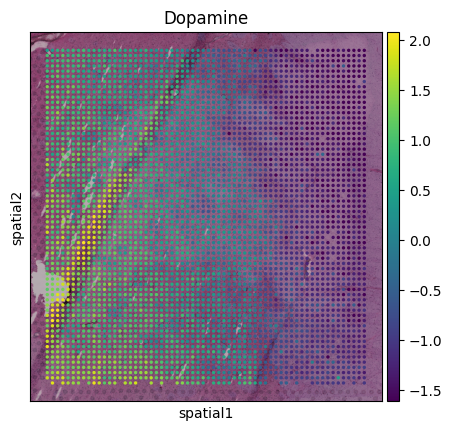

In [39]:
sc.pl.spatial(msi, color='Dopamine')

In [40]:
rna.layers['raw'] = rna.X.copy()
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

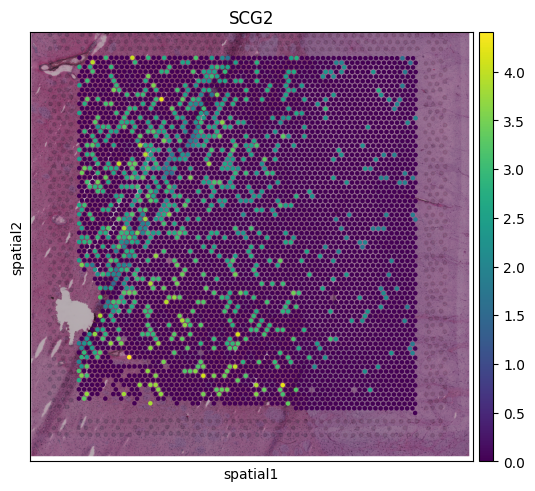

In [41]:
# annotations to msi
sq.pl.spatial_scatter(rna, color=['SCG2'], size=1.3)

In [42]:
msi.var.index = msi.var.index.astype(str)
msi.var['annotated'] = msi.var.index.astype(str)

In [43]:
# Write
mdata = mu.MuData({'rna':rna, 'msi':msi})
mdata = mu.MuData(mdata.mod)
mdata.write_h5mu(os.path.join(path, f"{exp}_{slide}.h5mu"))

In [44]:
import liana as li

In [45]:
# distances of metabolties to RNA
reference = mdata.mod["msi"].obsm["spatial"]

In [46]:
li.ut.spatial_neighbors(rna, bandwidth=1000, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)

In [47]:
mdata.update_obs()

In [48]:
# Load metabolite receptor interactions
resource =  pd.read_csv('applications/data/MR_brain_20230808.csv')
resource.head()

Unnamed: 0       ligand receptor
0           1  HMDB0000112   GABRB2
1           3  HMDB0000216   ADRA2B
2           4  HMDB0000068   ADRA2B
3          20  HMDB0000148     GRM8
4          49  HMDB0000112   GABRA5

In [49]:
receptors = np.intersect1d(resource['receptor'].unique(), rna.var.index)

In [50]:
receptors

array(['ADRA1A', 'ADRA2C', 'ADRB2', 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM4',
       'CHRNA10', 'CHRNA3', 'CHRNB1', 'CHRNB2', 'CNR1', 'DRD1', 'DRD2',
       'DRD4', 'ESR2', 'GABBR1', 'GABBR2', 'GABRA1', 'GABRA2', 'GABRA3',
       'GABRA4', 'GABRA5', 'GABRB1', 'GABRB2', 'GABRB3', 'GABRG1',
       'GABRG2', 'GABRG3', 'GLRB', 'GPER1', 'GPR17', 'GRIA1', 'GRIA2',
       'GRIA3', 'GRIA4', 'GRIK1', 'GRIK2', 'GRIK3', 'GRIK4', 'GRIK5',
       'GRIN1', 'GRIN2A', 'GRIN2B', 'GRIN3A', 'GRM1', 'GRM3', 'GRM4',
       'GRM5', 'GRM7', 'GRM8', 'GUCY1A1', 'GUCY1A2', 'GUCY1B1', 'HRH2',
       'HRH3', 'HTR1A', 'HTR1B', 'HTR1D', 'HTR1E', 'HTR2A', 'HTR2C',
       'HTR5A', 'NR1H2', 'NR1H3', 'NR3C1', 'NR3C2', 'PPARA', 'PTGDR',
       'RARA', 'RARB', 'RARG', 'RORA', 'RORB', 'RXRA', 'RXRB', 'RXRG',
       'SLC6A9'], dtype=object)

In [53]:
resource['ligand'].unique()

array(['HMDB0000112', 'HMDB0000216', 'HMDB0000068', 'HMDB0000148',
       'HMDB0000895', 'HMDB0001198', 'HMDB0001085', 'HMDB0004666',
       'HMDB0000259', 'HMDB0000073', 'HMDB0001852', 'HMDB0001452',
       'HMDB0000123', 'HMDB0000151', 'HMDB0002719', 'HMDB0002200',
       'HMDB0001403', 'HMDB0000870', 'HMDB0000067', 'HMDB0003378',
       'HMDB0000031', 'HMDB0001830', 'HMDB0001220', 'HMDB0000016',
       'HMDB0001547', 'HMDB0000234', 'HMDB0002961', 'HMDB0000053',
       'HMDB0001139', 'HMDB0000077', 'HMDB0000181', 'HMDB0000253',
       'HMDB0001335'], dtype=object)

In [191]:
sc.pp.highly_variable_genes(rna, n_top_genes=500)

In [192]:
annotated = msi.var.index.isin(molecule_weights.values())

In [193]:
misty = li.mt.MistyData({'intra':msi[:, annotated].copy(), 'extra':rna[:, receptors].copy()}, enforce_obs=False, obs=mdata.obs)

view intra is not a csr_matrix. Converting to csr_matrix


In [194]:
misty

MuData object with n_obs × n_vars = 8764 × 86
  obs:	'rna:in_tissue', 'rna:array_row', 'rna:array_col', 'rna:x', 'rna:y', 'rna:n_genes_by_counts', 'rna:log1p_n_genes_by_counts', 'rna:total_counts', 'rna:log1p_total_counts', 'rna:pct_counts_in_top_50_genes', 'rna:pct_counts_in_top_100_genes', 'rna:pct_counts_in_top_200_genes', 'rna:pct_counts_in_top_500_genes', 'rna:total_counts_mt', 'rna:log1p_total_counts_mt', 'rna:pct_counts_mt', 'rna:n_genes', 'rna:n_counts', 'msi:x', 'msi:y', 'msi:array_row', 'msi:array_col', 'msi:n_genes_by_counts', 'msi:log1p_n_genes_by_counts', 'msi:total_counts', 'msi:log1p_total_counts', 'msi:pct_counts_in_top_50_genes', 'msi:pct_counts_in_top_100_genes', 'msi:pct_counts_in_top_200_genes', 'msi:pct_counts_in_top_500_genes', 'msi:n_genes', 'msi:n_counts'
  var:	'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
  2 modalities
    intra:	3999 x 8
      obs:	'x', 'y', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'n_counts'
      var:	'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std', 'raw', 'mz', 'annotated'
      uns:	'spatial', 'log1p'
      obsm:	'spatial'
      layers:	'raw'
    extra:	4765 x 78
      obs:	'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'spatial', 'log1p', 'hvg'
      obsm:	'spatial', 'spatial_connectivities'
      layers:	'raw'

In [195]:
misty(model='linear', verbose=True, bypass_intra=True)

Now learning: Dopamine: 100%|██████████| 8/8 [00:09<00:00,  1.18s/it]         


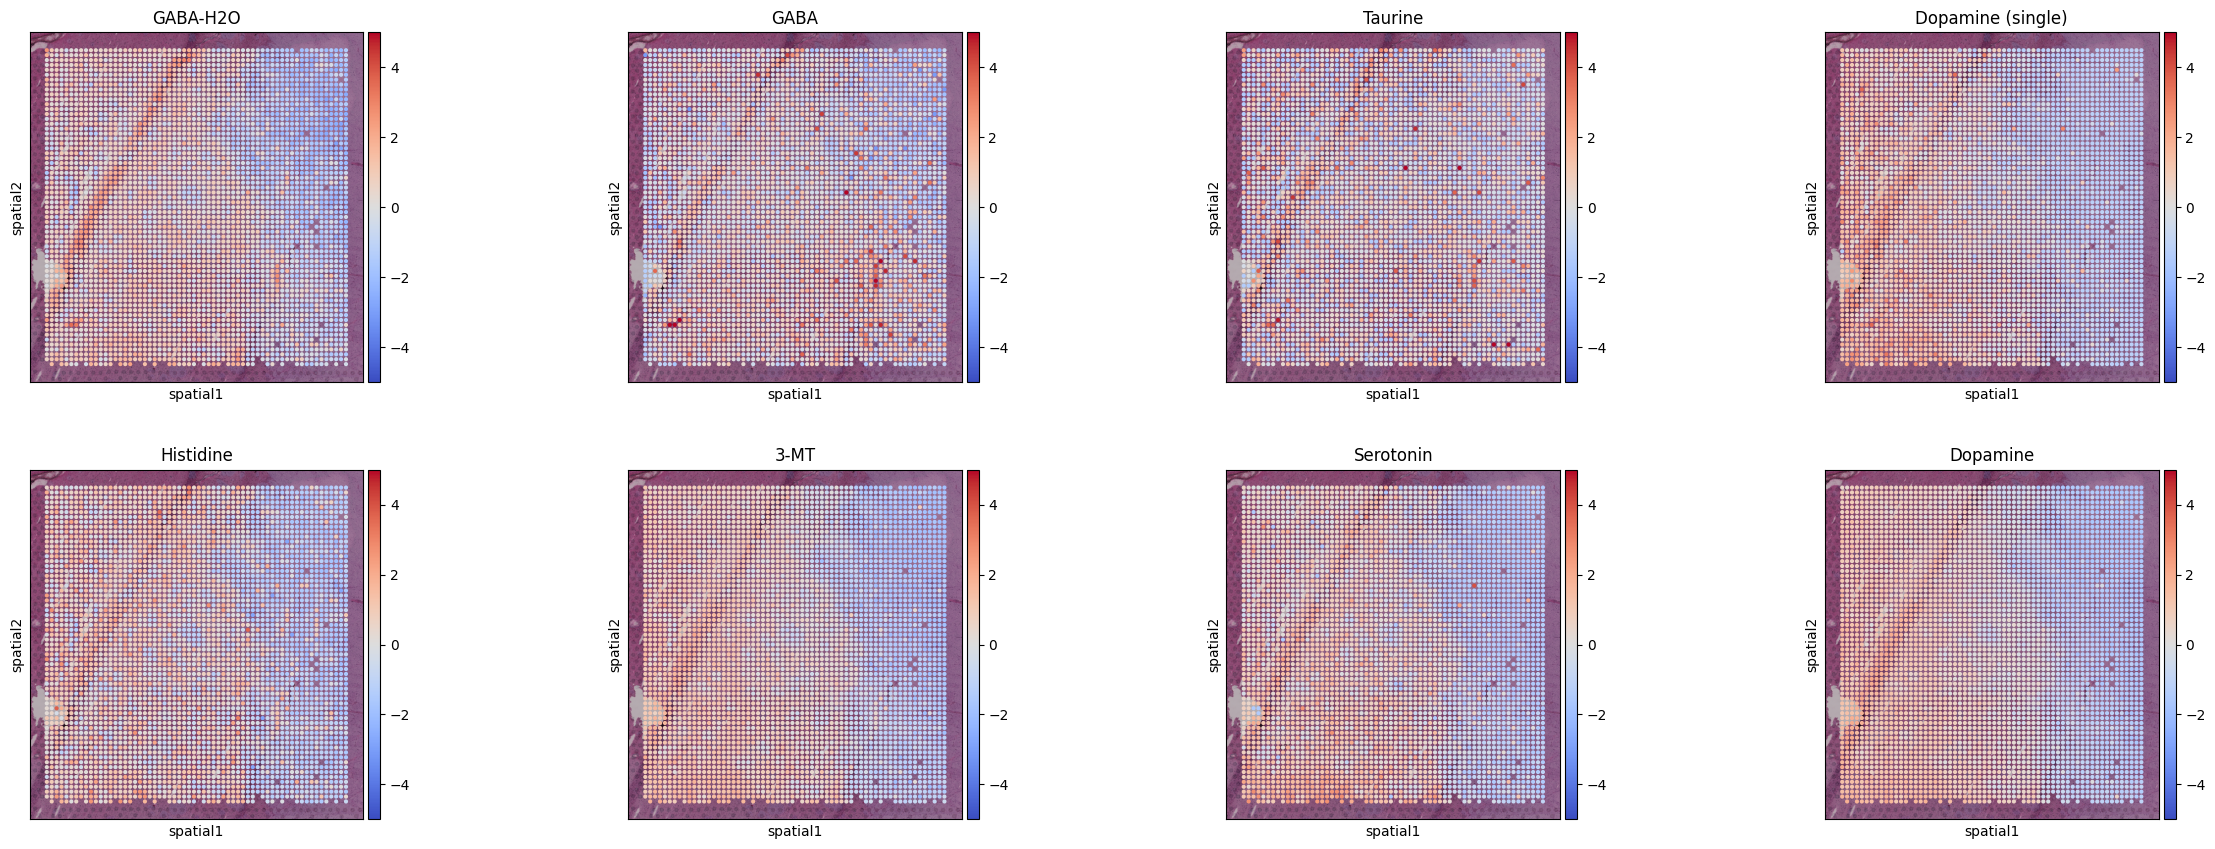

In [196]:
sc.pl.spatial(msi, color=msi.var.index[annotated], cmap='coolwarm', size=1.3, vmax=5, vmin=-5)

In [197]:
sc.pp.highly_variable_genes(msi, n_top_genes=10)

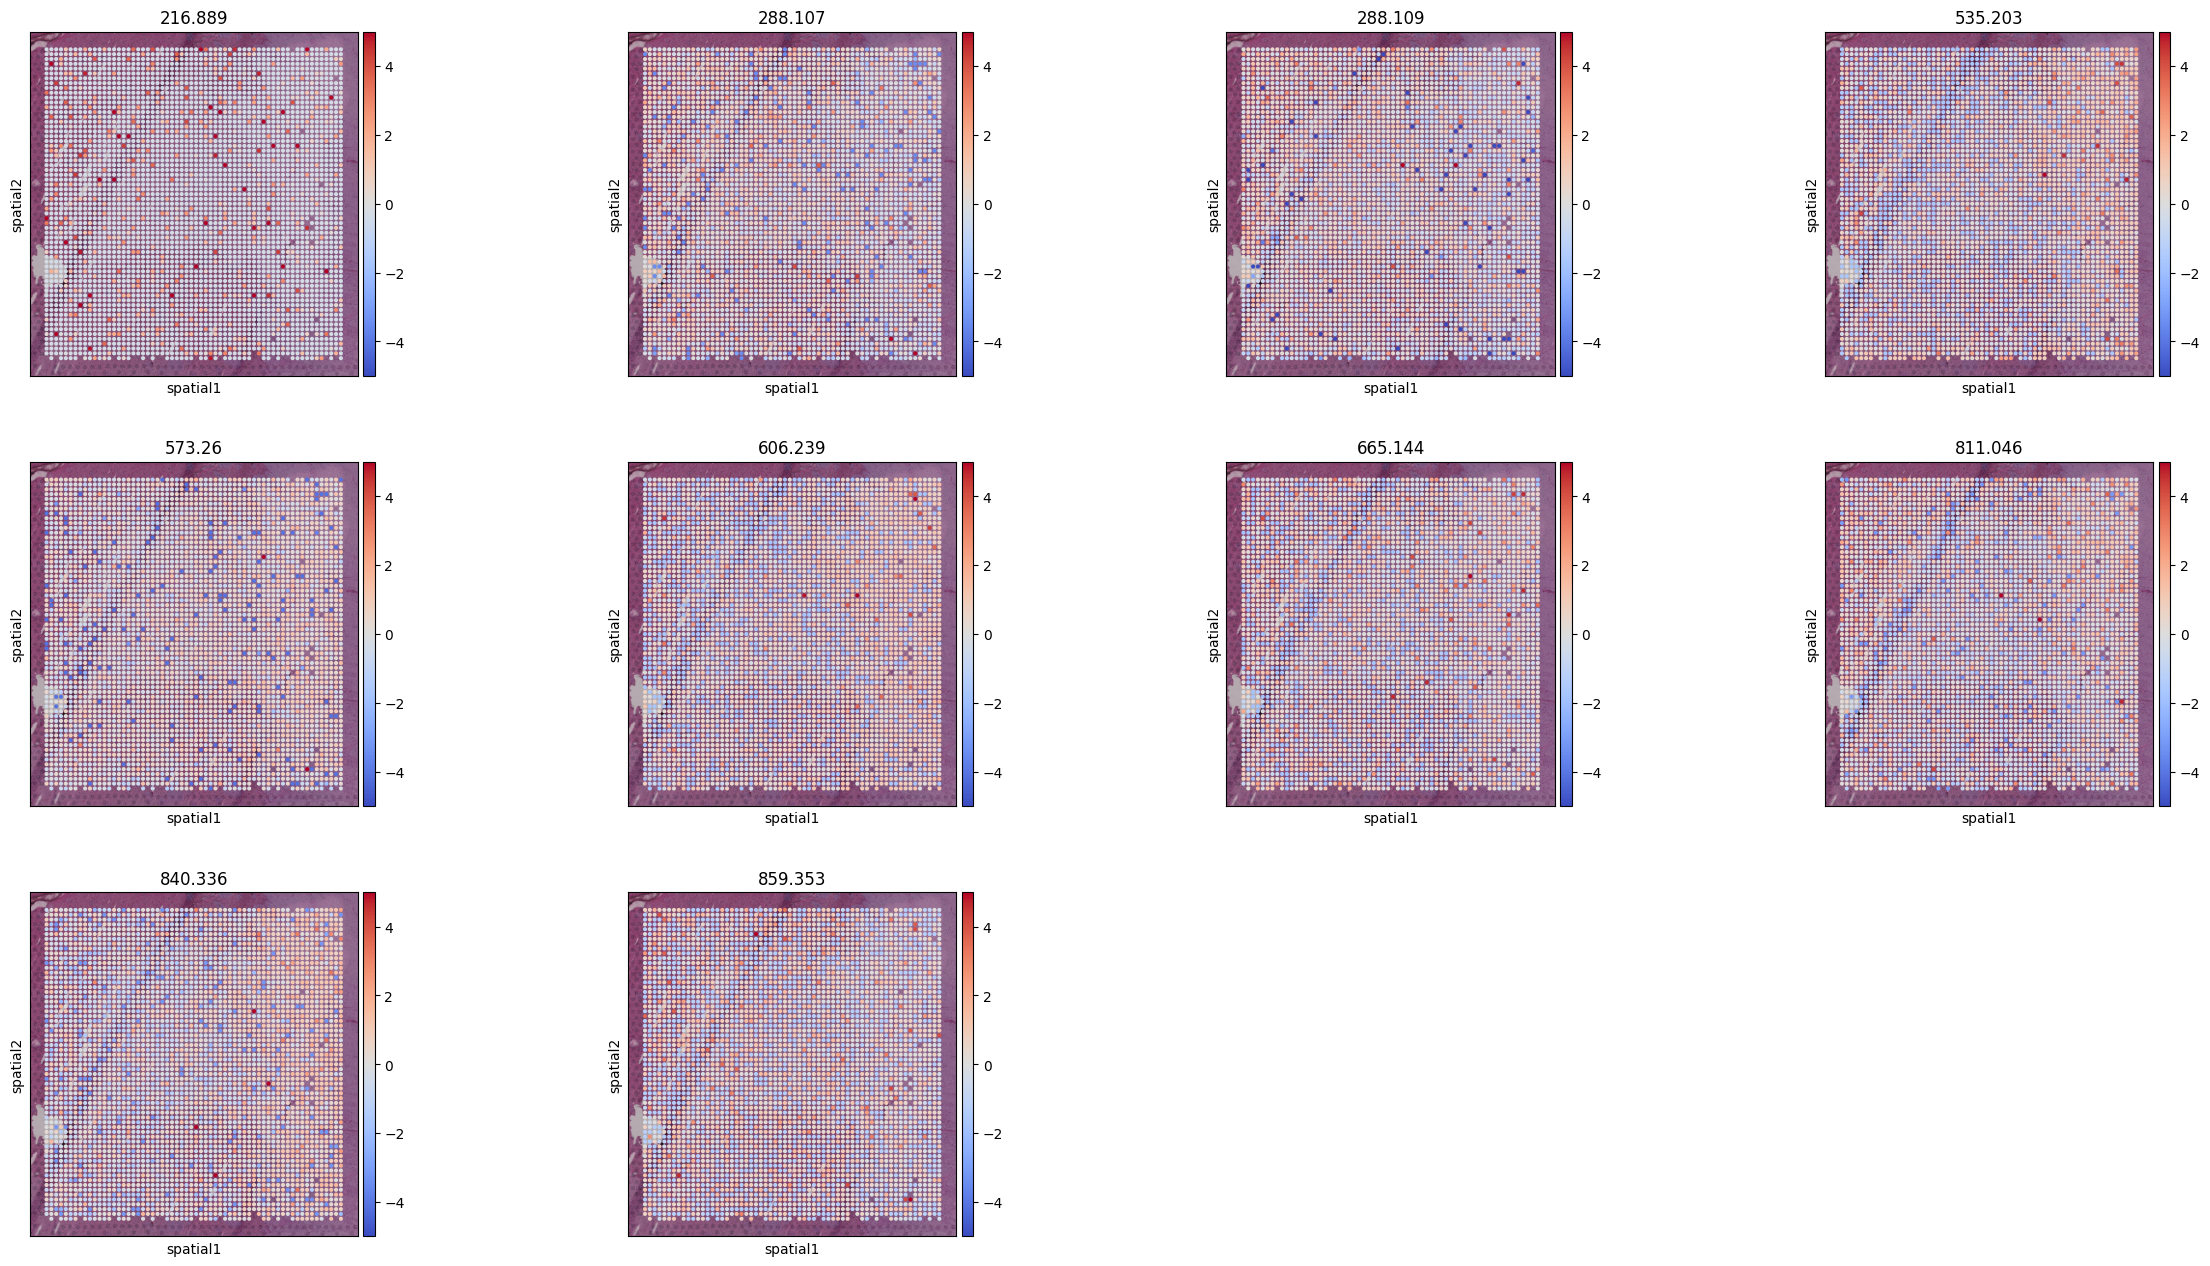

In [198]:
sc.pl.spatial(msi, color=msi.var[msi.var['highly_variable']].index, cmap='coolwarm', size=1.3, vmax=5, vmin=-5)

In [136]:
misty.uns['target_metrics']

target  intra_R2  multi_R2   gain_R2  extra
0           GABA-H2O         0  0.424393  0.424393    1.0
1               GABA         0  0.078776  0.078776    1.0
2            Taurine         0  0.005597  0.005597    1.0
3  Dopamine (single)         0  0.232082  0.232082    1.0
4          Histidine         0  0.327949  0.327949    1.0
5               3-MT         0  0.488656  0.488656    1.0
6          Serotonin         0  0.295340  0.295340    1.0
7           Dopamine         0  0.516333  0.516333    1.0

In [137]:
misty.uns['interactions'].sort_values("importances").tail(20)

target predictor   view  importances
501           Dopamine    GABRA5  extra     6.591812
430          Serotonin    GABRA2  extra     6.609487
262  Dopamine (single)     NR3C1  extra     6.669488
397               3-MT     HTR2C  extra     6.782012
366               3-MT    GABRB3  extra     6.882159
358               3-MT      ESR2  extra     7.088781
532           Dopamine     HTR1A  extra     7.154919
369               3-MT     GPER1  extra     7.833646
16            GABA-H2O    GABRA2  extra     7.968960
507           Dopamine     GPER1  extra     8.118204
510           Dopamine     GRIA2  extra     8.158761
400               3-MT     NR3C1  extra     8.475659
409               3-MT      RORB  extra     8.525022
538           Dopamine     NR3C1  extra     8.546796
496           Dopamine      ESR2  extra     8.639538
547           Dopamine      RORB  extra     8.769598
372               3-MT     GRIA2  extra     9.014346
223  Dopamine (single)    GABRA2  extra    10.142610
361               3-MT    GABRA2  extra    13.741884
499           Dopamine    GABRA2  extra    15.217320